In [30]:
import cv2
import os
import random
import matplotlib.pyplot as plt
from ultralytics import YOLO


# Result Display Examples

## Single Result

In [56]:
def extract_bbox_from_filename(filename):
    """
    Extract bounding box coordinates (x1, y1, x2, y2) from the CCPD filename.
    """
    parts = filename.split('-')
    rec_x1y1 = parts[2].split('_')[0].split('&')
    rec_x2y2 = parts[2].split('_')[1].split('&')
    x1, y1 = int(rec_x1y1[0]), int(rec_x1y1[1])
    x2, y2 = int(rec_x2y2[0]), int(rec_x2y2[1])
    return x1, y1, x2, y2

def calculate_iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    intersection_area = max(0, x2 - x1) * max(0, y2 - y1)

    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    union_area = box1_area + box2_area - intersection_area

    if union_area == 0:
        return 0

    # IoU
    return intersection_area / union_area

def detect_license_plate_ccpd(image_path, model):
    img = cv2.imread(image_path)

    # Run the YOLO model on the image to get predictions
    results = model(img)
    predictions = results[0].boxes 

    # Extract actual bounding box from the filename
    actual_x1, actual_y1, actual_x2, actual_y2 = extract_bbox_from_filename(image_path.split('/')[-1])
    actual_box = (actual_x1, actual_y1, actual_x2, actual_y2)

    best_iou = 0
    best_confidence = 0

    for box in predictions:
        x1, y1, x2, y2 = map(int, box.xyxy[0])  # Predicted coordinates
        confidence = float(box.conf[0])        # Confidence score

        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2) 
        cv2.putText(img, f"Predicted", (x1, y2 + 20), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

        predicted_box = (x1, y1, x2, y2)
        iou = calculate_iou(actual_box, predicted_box)

        if iou > best_iou:
            best_iou = iou
            best_confidence = confidence

    cv2.rectangle(img, (actual_x1, actual_y1), (actual_x2, actual_y2), (255, 0, 0), 2)  
    cv2.putText(img, "Actual", (actual_x1, actual_y1 - 10), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 10))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title(f"IoU: {round(best_iou*100,2)}% | Confidence: {round(best_confidence*100,2)}%")
    plt.show()

    return {
        'best_iou': best_iou,
        'best_confidence': best_confidence
    }


0: 640x416 1 license_plate, 109.9ms
Speed: 16.5ms preprocess, 109.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 416)


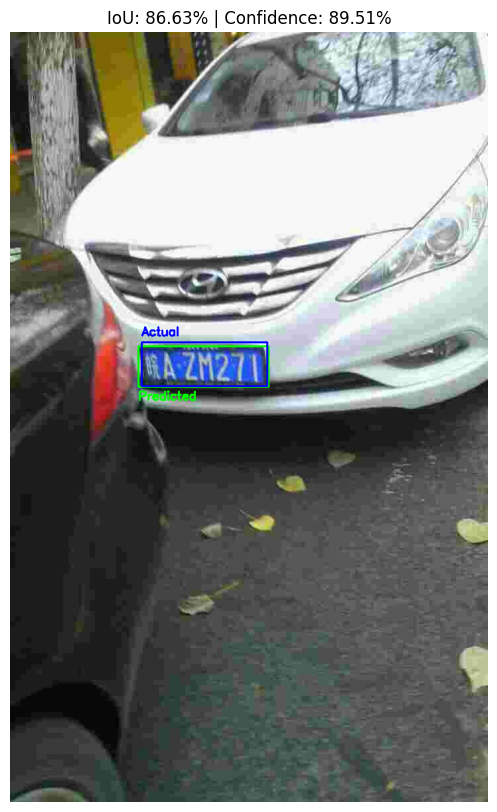

{'best_iou': 0.8663101604278075, 'best_confidence': 0.8951056599617004}

In [57]:
model_1k_tune = YOLO('models/yolov8_ccpd_1k_tuned.pt')

# Path to a CCPD2019 image
image_path = '/CCPD2019/ccpd_structure/images/test/00990421455938-90_88-198&467_387&533-394&540_203&537_195&467_386&470-0_0_23_11_26_31_25-111-20.jpg'
detect_license_plate_ccpd(image_path, model_1k_tune)


## Multiple stacked outputs

In [69]:
def visualize_random_images(folder_path, model, num_images=3):
    image_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.jpg')]

    selected_images = random.sample(image_paths, num_images)

    fig, axs = plt.subplots(1, num_images, figsize=(15, 5))
    if num_images == 1:
        axs = [axs] 

    for idx, image_path in enumerate(selected_images):
        metrics = detect_license_plate_ccpd(image_path, model)

        if metrics['image'] is not None:
            axs[idx].imshow(metrics['image'])
            axs[idx].axis('off')
            axs[idx].set_title(f"IoU: {metrics['best_iou']:.2f}\nConf: {metrics['best_confidence']:.2f}")
        else:
            axs[idx].axis('off')
            axs[idx].set_title("Error reading image")

    plt.tight_layout()
    plt.show()



0: 640x416 1 license_plate, 80.3ms
Speed: 2.2ms preprocess, 80.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 416)

0: 640x416 1 license_plate, 58.6ms
Speed: 1.9ms preprocess, 58.6ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 416)

0: 640x416 1 license_plate, 69.4ms
Speed: 1.9ms preprocess, 69.4ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 416)


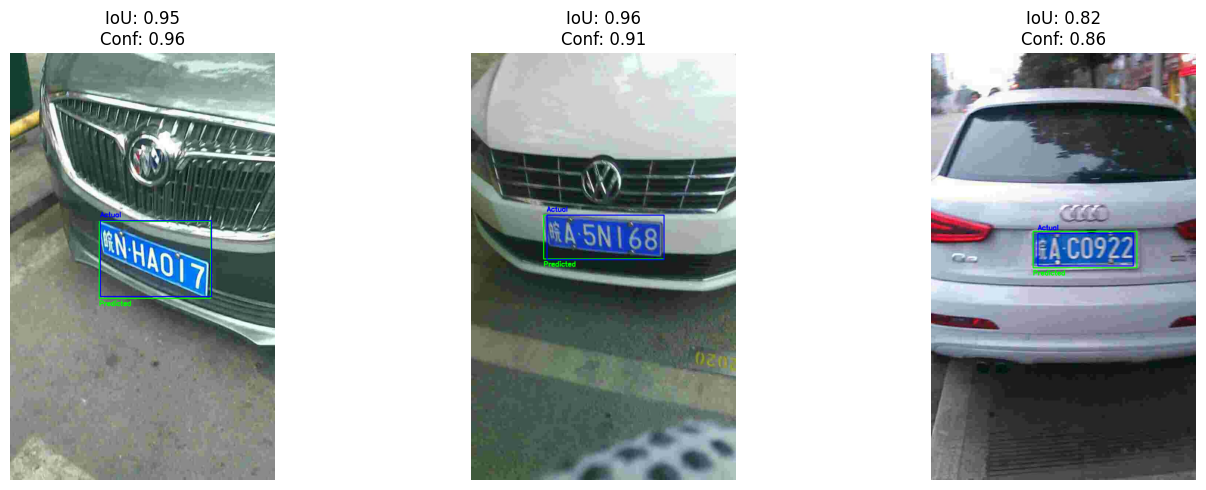

In [77]:
folder_path = '/CCPD2019/ccpd_structure/images/test/'

# Visualize results for 3 random images
visualize_random_images(folder_path, model_1k_tune, num_images=3)